In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
from skimage.feature import hog

%matplotlib inline

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

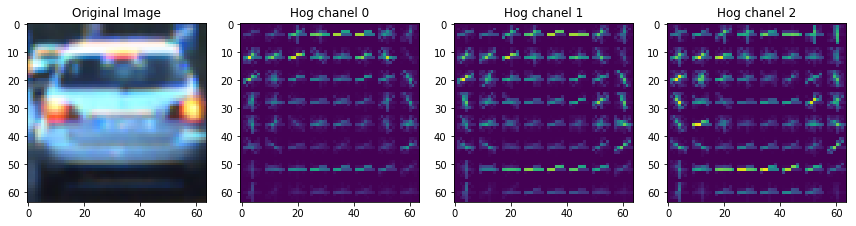

In [2]:
image = cv2.imread('test_images/5959.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(142)
features, hog_image = get_hog_features(image[:, :, 0], 16, 8, 2, True)
plt.imshow(hog_image)
plt.title('Hog chanel 0')
    
plt.subplot(143)
features, hog_image = get_hog_features(image[:, :, 1], 16, 8, 2, True)
plt.imshow(hog_image)
plt.title('Hog chanel 1')

plt.subplot(144)
features, hog_image = get_hog_features(image[:, :, 2], 16, 8, 2, True)
plt.imshow(hog_image)
plt.title('Hog chanel 2')


fig.tight_layout()
fig.savefig("output_images/hog_features_car.jpg")


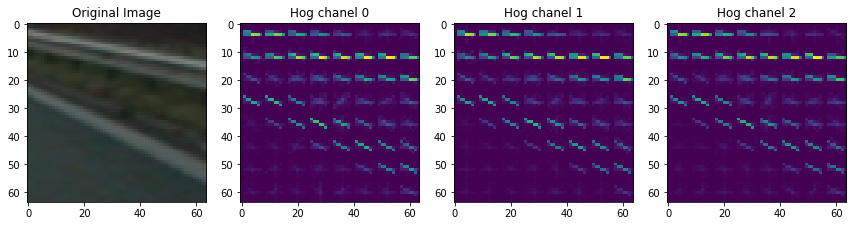

In [3]:
image = cv2.imread('test_images/image3710.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(142)
features, hog_image = get_hog_features(image[:, :, 0], 16, 8, 2, True)
plt.imshow(hog_image)
plt.title('Hog chanel 0')
    
plt.subplot(143)
features, hog_image = get_hog_features(image[:, :, 1], 16, 8, 2, True)
plt.imshow(hog_image)
plt.title('Hog chanel 1')

plt.subplot(144)
features, hog_image = get_hog_features(image[:, :, 2], 16, 8, 2, True)
plt.imshow(hog_image)
plt.title('Hog chanel 2')

fig.tight_layout()
fig.savefig("output_images/hog_features_not_car.jpg")

Cars samples:  8792
Not cars samples:  8792


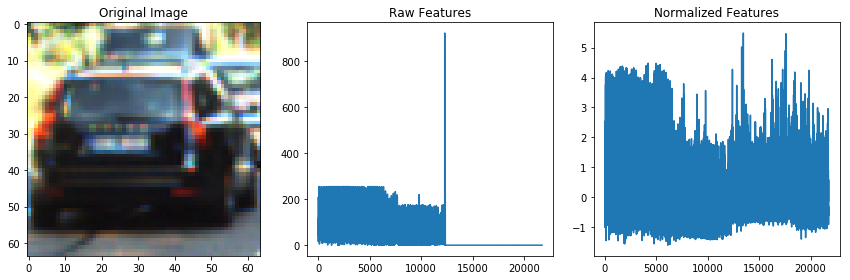

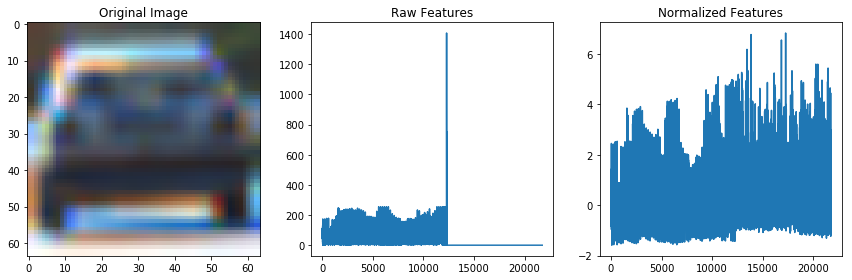

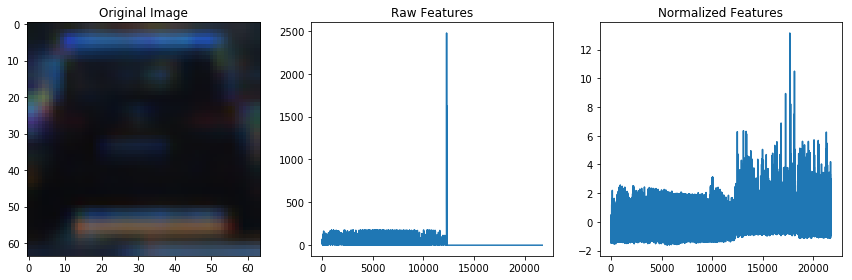

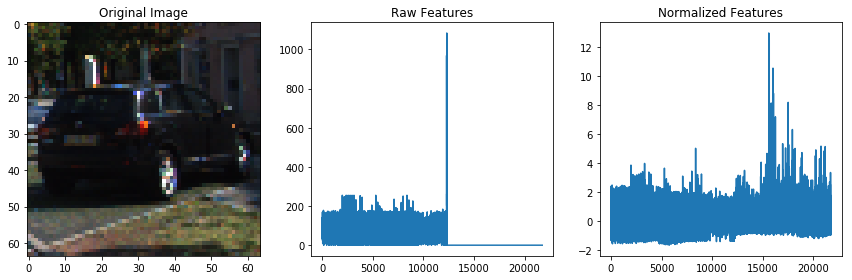

In [4]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image =  cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def load_train_data():
    cars_folders = ["train_data/vehicles/*/", ]
    
    not_cars_folders = ["train_data/non-vehicles/*/",]
    
    cars = []
    notcars = []
    
    for f in cars_folders:
        cars += glob.glob(f + '*.png')  
    
    for f in not_cars_folders:
        notcars += glob.glob(f + '*.png')  
        
    # Limit sets to the same size
    size = min([len(cars), len(notcars)])
    cars = cars[:size]
    notcars = notcars[:size]
    return cars, notcars


cars, notcars = load_train_data()
print("Cars samples: ", len(cars))
print("Not cars samples: ", len(notcars))
                
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 18    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None]


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

if len(car_features) == 0:
    print('Your function only returns empty feature vectors...')
else:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    for i in range(1, 5):
        car_ind = np.random.randint(0, len(cars))
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(cars[car_ind]))
        plt.title('Original Image')
        plt.subplot(132)
        plt.plot(X[car_ind])
        plt.title('Raw Features')
        plt.subplot(133)
        plt.plot(scaled_X[car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
        plt.show()
        fig.savefig("output_images/normalized_features_{0}.jpg".format(i))
        

In [5]:
import time

from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

def train_model(car_features, notcar_features):
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    print("Y size:", len(y))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return svc

svc = train_model(car_features, notcar_features)

/Users/dis/miniconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Y size: 17584
Using: 16 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 21750
39.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9923


In [6]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

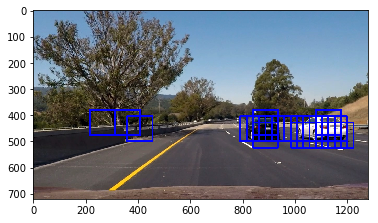

In [7]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, 
              scale, svc, X_scaler, 
              orient, 
              pix_per_cell, 
              cell_per_block, 
              spatial_size, 
              hist_bins,
              xstart=None,
              xstop=None):
    
    draw_img = np.copy(img)
    
    if xstart is None:
        xstart = 0
    if xstop is None:
        xstop = img.shape[1]
        
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HLS')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    predictions = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                prediction = ((xbox_left + xstart, ytop_draw+ystart),
                              (xbox_left + + xstart + win_draw,ytop_draw+win_draw+ystart))
                
                predictions.append(prediction)
                
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return predictions
    
ystart = 380
ystop = 656
scale = 1.5

image = mpimg.imread('test_images/test6.jpg')

predictions = find_cars(image, ystart, ystop, 
                        scale, svc, X_scaler, orient, 
                        pix_per_cell, cell_per_block, 
                        spatial_size, hist_bins)

out_img = draw_boxes(image, predictions, color=(0, 0, 255), thick=6) 
plt.imshow(out_img)
plt.savefig("output_images/found_cars.jpg")

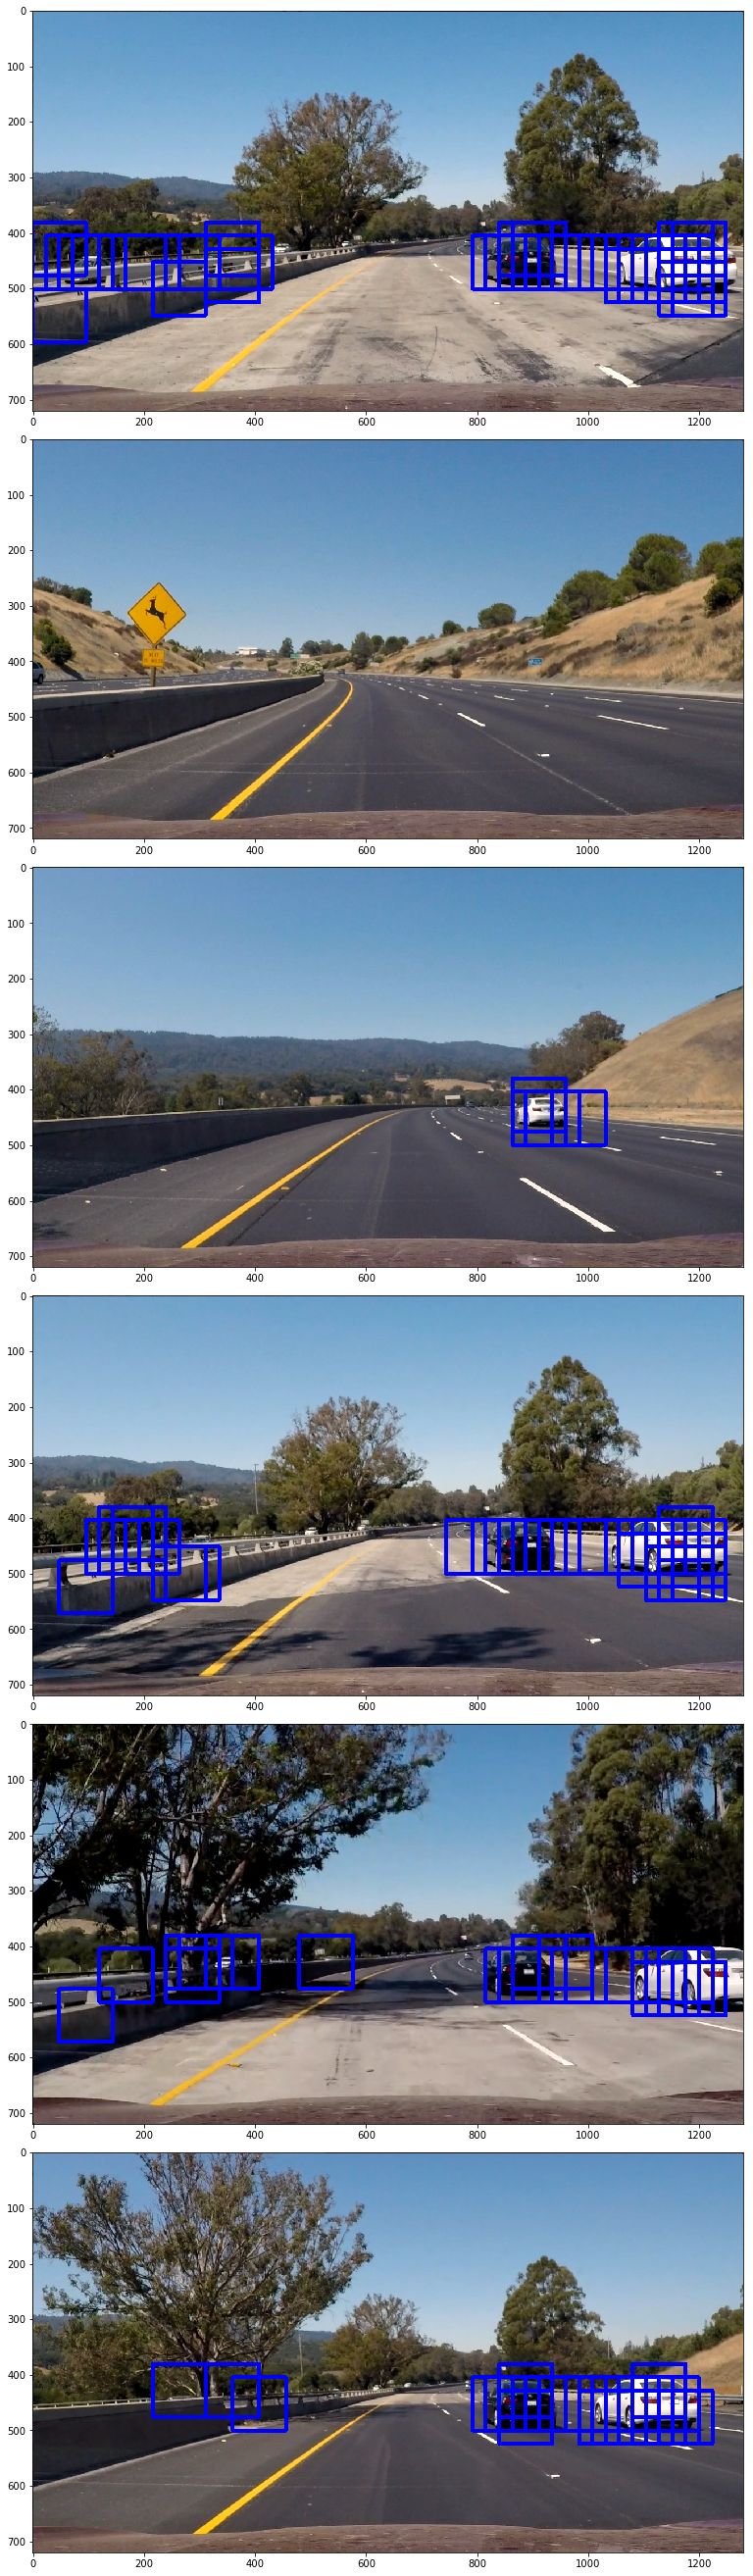

In [8]:
test_images = glob.glob("test_images/" + '*.jpg') 

fig, subs = plt.subplots(len(test_images), 1, figsize=(140,40))
fig.tight_layout()

for i, f in enumerate(test_images):
    image = mpimg.imread(f)

    predictions = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                            orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    out_img = draw_boxes(image, predictions, color=(0, 0, 255), thick=6) 
    subs[i].imshow(out_img)
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("output_images/found_cars_all_tests.jpg")

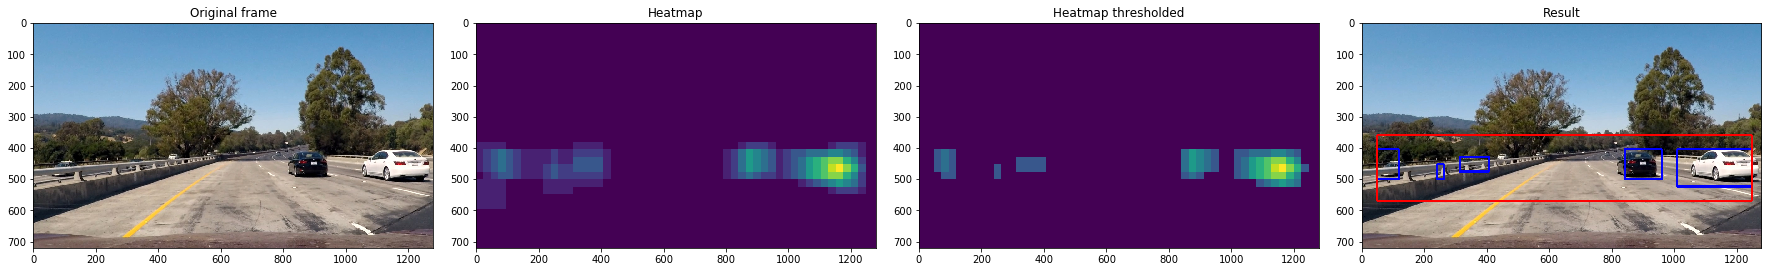

In [9]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    
    selected_boxes = []
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        selected_boxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, selected_boxes

def find_region_of_interest(img, labels, y_start, y_stop, margin_x=50, margin_y=45, draw=False):
    # Find pixels with all cars
    nonzero = (labels[0] != 0).nonzero()
    # Identify x and y values of those pixels
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Define a bounding box based on min/max x and y
    
    if len(nonzerox) == 0:
        min_x = 0
        max_x = img.shape[1]
    else:
        min_x = np.min(nonzerox)
        if min_x >= margin_x:
            min_x -= margin_x
            
        max_x = np.max(nonzerox)
        if max_x < (img.shape[1] - margin_x):
            max_x += margin_x
        
    if len(nonzeroy) == 0:
        min_y = y_start
        max_y = y_stop
    else:
        min_y = np.min(nonzeroy)
        if min_y > y_start:
            min_y -= margin_y
            
        max_y = np.max(nonzeroy)
        if max_y < (y_stop - margin_y):
            max_y += margin_y
    
    bbox = (( min_x, min_y), 
            (max_x, max_y))
    
    # Draw the box on the image
    if draw:
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
        
    return bbox


fig, subs = plt.subplots(1, 4, figsize=(24,9))
fig.tight_layout()

image = mpimg.imread("test_images/test1.jpg")

predictions = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
                         
                        
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, predictions)    
subs[0].imshow(image)
subs[0].set_title("Original frame")
subs[1].imshow(heatmap)          
subs[1].set_title("Heatmap")

heatmap = apply_threshold(heatmap, 2)
subs[2].imshow(heatmap)      
subs[2].set_title("Heatmap thresholded")
                         
labels = label(heatmap)

draw_img, selected_boxes = draw_labeled_bboxes(np.copy(image), labels)

region_of_interest = find_region_of_interest(draw_img, labels, ystart, ystop, draw=True)

subs[3].imshow(draw_img)
subs[3].set_title("Result")
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plt.savefig("output_images/found_cars_region_of_interest.jpg")

In [10]:
class FrameProcessor:
    def __init__(self, ystart, ystop, full_search_on_frame=25, heatmap_treshold=3):
        self.ystart = ystart
        self.ystop = ystop
        self.full_search_on_frame = full_search_on_frame
        self.frame_number = 0
        self.labels = None
        self.heatmap_treshold=heatmap_treshold
        self.predictions = []
        
    
    def __search(self, frame):
        full_search = True
        if (self.frame_number % self.full_search_on_frame) != 0 and self.labels:
            region_of_interest = find_region_of_interest(frame, self.labels, 
                                                         self.ystart, self.ystop, draw=True)
            x_start = region_of_interest[0][0]
            x_stop = region_of_interest[1][0]
            y_start = region_of_interest[0][1]
            y_stop = region_of_interest[1][1]
            full_search = False
        else:
            y_start = self.ystart
            y_stop =self.ystop
            x_start = None
            x_stop = None
        
        predictions = find_cars(frame, y_start, y_stop, 
                                scale, svc, X_scaler, 
                                orient, pix_per_cell, 
                                cell_per_block, 
                                spatial_size, 
                                hist_bins,
                                xstart=x_start, xstop=x_stop)
        
        frame = draw_boxes(frame, predictions, color=(0, 255, 255), thick=1)
    
        heatmap = np.zeros_like(frame[:,:,0]).astype(np.float)
        heatmap = add_heat(heatmap, self.predictions + predictions)

        if full_search:
            threshhold = self.heatmap_treshold
        else:
            threshhold = 2

        heatmap = apply_threshold(heatmap, threshhold)

        self.labels = label(heatmap)
        frame,  predictions = draw_labeled_bboxes(np.copy(frame), self.labels)  

        if len(predictions) != 0:
            self.predictions = predictions
        else:
            if full_search:
                self.predictions = []
                
            # do full search one more time
            self.frame_number = -1
            
        return frame
        
        
    def process(self, frame):
        if (self.frame_number % self.full_search_on_frame) == 0:
            self.labels = []
            
        res = self.__search(frame)
        
        self.frame_number += 1
        
        return res

fp = FrameProcessor(ystart, ystop)

def process_frame(frame):
    return fp.process(frame)

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')

project_clip = clip.fl_image(process_frame)
%time project_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:47<00:00,  3.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 41s, sys: 6.5 s, total: 2min 48s
Wall time: 2min 47s
